In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import glob

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

import shutil

あらかじめ Yolo_v5 は git clone しておく

現在のデータセットは以下のようなディレクトリ構成になっています。

dataset
   |_train
   |  |_Bear
   |     |_Label
   |     |   |_001.txt
   |     |   |_002.txt
   |     |      ︙
   |     |_001.jpg
   |     |_002.jpg
   |       ︙


ですが、YOLOでは学習のために以下のようなディレクトリ構成が要請されているため、それに合わせる必要があります。

dataset_for_yolo
   |_images
   |  |_train
   |     |_001.jpg
   |     |_002.jpg
   |       ︙
   |_labels
      |_train
         |_001.txt
         |_002.txt
           ︙


In [27]:
# クラス名が（実際にはラベルテキストが） Brown Bear/ Polar Bearのように変にスペースされているせいで次での処理がバグるので、先にこの2クラスだけ直しておく

label_list = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brown bear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polar bear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]

def fill_space_in_labels(input_labels_dir, output_labels_dir, class_names_with_space):
    os.makedirs(output_labels_dir, exist_ok=True)

    for label_file_name in os.listdir(input_labels_dir):
        if not label_file_name.endswith(".txt"):
            continue

        input_label_file_path = os.path.join(input_labels_dir, label_file_name)
        output_label_file_path = os.path.join(output_labels_dir, label_file_name)

        print(input_label_file_path)
        with open(input_label_file_path, "r") as input_file, open(output_label_file_path, "w") as output_file:
            print(input_file)
            for line in input_file:
                print(line)
                for class_name in class_names_with_space:
                    filled_class_name = class_name.replace(" ", "")
                    line = line.replace(class_name, filled_class_name)
                output_file.write(line)


In [ ]:
# trainデータ

class_names_with_space = ["Polar bear", "Brown bear"]
input_base_dir = "dataset/train/"
output_base_dir_fixed = "dataset/train/"

for class_name in class_names_with_space:
    class_name_fixed = class_name.replace(" ", "")

    input_labels_dir = os.path.join(input_base_dir, class_name, "Label") if class_name else os.path.join(input_base_dir, class_name, "Label")
    print(input_labels_dir)
    output_labels_dir_fixed = os.path.join(output_base_dir_fixed, class_name_fixed, "Label")

    fill_space_in_labels(input_labels_dir, output_labels_dir_fixed, class_names_with_space)


In [ ]:
# testデータ

class_names_with_space = ["Polar bear", "Brown bear"]
input_base_dir = "dataset/test/"
output_base_dir_fixed = "dataset/test/"

for class_name in class_names_with_space:
    class_name_fixed = class_name.replace(" ", "")

    input_labels_dir = os.path.join(input_base_dir, class_name, "Label") if class_name else os.path.join(input_base_dir, class_name, "Label")
    print(input_labels_dir)
    output_labels_dir_fixed = os.path.join(output_base_dir_fixed, class_name_fixed, "Label")

    fill_space_in_labels(input_labels_dir, output_labels_dir_fixed, class_names_with_space)


ここで、notebookを追う方は、（trainやtestそれぞれについて）空白ありのBrown BearやPolar bearに含まれる画像を空白なしのBrownbearやPolarBearにコピペしてください

In [21]:
%cd /Users/sawaki/product/CA_tech_lounge/Assignment3/

/Users/sawaki/product/CA_tech_lounge/Assignment3


In [19]:
# 各画像もdataset_yolo/imagesにコピーする

def copy_images(src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)

    for file_name in os.listdir(src_dir):
        if not file_name.endswith(".jpg"):
            continue

        src_file_path = os.path.join(src_dir, file_name)
        dest_file_path = os.path.join(dest_dir, file_name)

        shutil.copyfile(src_file_path, dest_file_path)


In [22]:

label_list = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brownbear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polarbear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]
input_base_dir = "dataset/train/"
output_images_dir = "dataset_yolo/images/train/"

for label in label_list:
    input_image_dir = os.path.join(input_base_dir, label)

    copy_images(input_image_dir, output_images_dir)

In [23]:
label_list = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brown bear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polar bear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]
input_base_dir = "dataset/test/"
output_images_dir = "dataset_yolo/images/test/"

for label in label_list:
    input_image_dir = os.path.join(input_base_dir, label)

    copy_images(input_image_dir, output_images_dir)

In [9]:
# アノテーションフォーマットに合わせるための変換

def convert_annotation(label_file, img_file, output_file, label_list):
    with open(label_file, 'r') as f:
        lines = f.readlines()
        print(lines)

    img = Image.open(img_file)
    img_width, img_height = img.size

    converted_lines = []

    for line in lines:
            
        parts = line.strip().split()
        if len(parts) != 5: print(line, parts)
        label, x_min, y_min, x_max, y_max = parts
        class_id = label_list.index(label)
        #class_id = label

        #labelテキストから x中心、y中心、 幅、高さ を計算
        x_center = (float(x_min) + float(x_max)) / 2
        y_center = (float(y_min) + float(y_max)) / 2
        width = float(x_max) - float(x_min)
        height = float(y_max) - float(y_min)

        # バウンディングボックスは座標ではなく、画像サイズで正規化された0~1で表現
        x_center_normalized = x_center / img_width
        y_center_normalized = y_center / img_height
        width_normalized = width / img_width
        height_normalized = height / img_height

        converted_line = f"{class_id} {x_center_normalized} {y_center_normalized} {width_normalized} {height_normalized}"
        converted_lines.append(converted_line)

    with open(output_file, 'w') as f:
        f.write("\n".join(converted_lines))


In [ ]:
# Yolo用のデータセットディレクトリを作るための変換

# trainデータ

label_list = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brownbear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polarbear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]

input_base_dir = "dataset/train/"
output_base_dir = "dataset_yolo/labels/train/"

for class_name in label_list:
    input_labels_dir = os.path.join(input_base_dir, class_name, "Label")
    input_images_dir = os.path.join(input_base_dir, class_name)
    output_labels_dir = os.path.join(output_base_dir)

    os.makedirs(output_labels_dir, exist_ok=True)

    for label_file_name in os.listdir(input_labels_dir):
        if not label_file_name.endswith(".txt"):
            continue

        label_file_path = os.path.join(input_labels_dir, label_file_name)
        img_file_name = f"{label_file_name.replace('.txt', '.jpg')}"
        img_file_path = os.path.join(input_images_dir, img_file_name)
        output_file_name = f"{label_file_name}"
        output_file_path = os.path.join(output_labels_dir, output_file_name)

        print(label_file_path, img_file_path, output_file_path)
        convert_annotation(label_file_path, img_file_path, output_file_path, label_list)


In [ ]:
# Yolo用のデータセットディレクトリを作るための変換

# testデータ

label_list = ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brownbear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polarbear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar','Duck' ]

input_base_dir = "dataset/test/"
output_base_dir = "dataset_yolo/labels/test/"

for class_name in label_list:
    input_labels_dir = os.path.join(input_base_dir, class_name, "Label")
    input_images_dir = os.path.join(input_base_dir, class_name)
    output_labels_dir = os.path.join(output_base_dir)

    os.makedirs(output_labels_dir, exist_ok=True)

    for label_file_name in os.listdir(input_labels_dir):
        if not label_file_name.endswith(".txt"):
            continue

        label_file_path = os.path.join(input_labels_dir, label_file_name)
        img_file_name = f"{label_file_name.replace('.txt', '.jpg')}"
        img_file_path = os.path.join(input_images_dir, img_file_name)
        output_file_name = f"{label_file_name}"
        output_file_path = os.path.join(output_labels_dir, output_file_name)

        print(label_file_path, img_file_path, output_file_path)
        convert_annotation(label_file_path, img_file_path, output_file_path, label_list)


ここで、yolov5/dataディレクトリに以下のmy_dataset.yamlを作成

train: ../dataset_yolo/images/train/
val: ../dataset_yolo/images/test/

nc: 19  # クラス数
names: ['Zebra', 'Lion', 'Leopard' , 'Cheetah', 'Tiger', 'Bear' ,'Brownbear' ,'Butterfly', 'Canary' ,'Crocodile', 'Polarbear','Bull','Camel','Crab','Chicken','Centipede','Cattle','Caterpillar', 'Duck' ]

今回はyolov5sを用いるため、さらに yolov5/models/yolov5s.yaml を開き fc=19（分類クラス）とする

In [ ]:
# 学習する
#%cd yolov5
!python train.py --img 224 --batch 64 --epochs 10 --data data/my_dataset.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_CA_assignment3_2 --cache --freeze 10

In [ ]:
tensorboard --load_fast=false --logdir runs/train

In [ ]:
%cd /Users/sawaki/product/CA_tech_lounge/Assignment3/yolov5/
!python detect.py --source /Users/sawaki/product/CA_tech_lounge/Assignment3/dataset_yolo/images/test --weights runs/train/yolov5s_CA_assignment3_2/weights/best.pt --conf 0.20

通常の推論では、バウンディングボックスが付された画像が出力されるだけのため、座標やラベルを変数として取得することができません。
そのため、yolov5/output_dirを作り、yolov5ディレクトリにあるdetect.pyをいじって、json形式でそこに吐き出させることにします。

In [37]:
%cd /Users/sawaki/product/CA_tech_lounge/Assignment3/yolov5/
os.makedirs('output_dir', exist_ok=True)

/Users/sawaki/product/CA_tech_lounge/Assignment3/yolov5


In [ ]:
# detect.pyのrun()後半にこれを追加

# 出力先
output_detection_dir = 'output_dir'

#print(p.name)
json_data = []

# tensor型[x1,y1,x2,y2,確信度,ラベル]がpredに格納されている。複数検知する場合もあるのでfor文で回してappendしていく
# 謎にカッコで囲まれてるのでpred[0]とする
for pr in pred[0]:
    x1, y1, x2, y2, confidence, class_id = pr.tolist()
    json_data.append({
        'filename': p.name, #画像の名前
        'coordinates': [x1, y1, x2, y2],
        'confidence': confidence,
        'class_id': int(class_id)
    })

# 画像と同じ名前のjsonに
json_filename = os.path.join(output_detection_dir, os.path.basename(p.name).replace('.jpg', '.json'))

# 書き出し
with open(json_filename, 'w') as f:
    json.dump(json_data, f, indent=4)   


実際に呼び出してみる

In [53]:
%cd /Users/sawaki/product/CA_tech_lounge/Assignment3/

/Users/sawaki/product/CA_tech_lounge/Assignment3


In [107]:
# インデックスを指定して座標やラベルを表示する
def get_result(idx, detected_folder="dataset_yolo/images/test/", output='yolov5/runs/detect/exp3'):

    files_path = os.listdir(detected_folder)

    filename = files_path[idx]
    result_image = '{}/{}'.format(output, filename)

    # detect.pyで出力された画像
    img = Image.open(result_image)
    img = np.asarray(img)
    plt.imshow(img)
    plt.show()

    json_path = 'yolov5/output_dir/{}'.format(filename.replace('.jpg', '.json'))
    result_json = json.load(open(json_path, 'r'))

    for i in range(len(result_json)):
        print('Class:', result_json[i]['class_id'],
            '  Bounding Box: (x1,y1,x2,y2)=', result_json[i]['coordinates'],
            ' (confidence:', result_json[i]['confidence'], ')')

    
    return


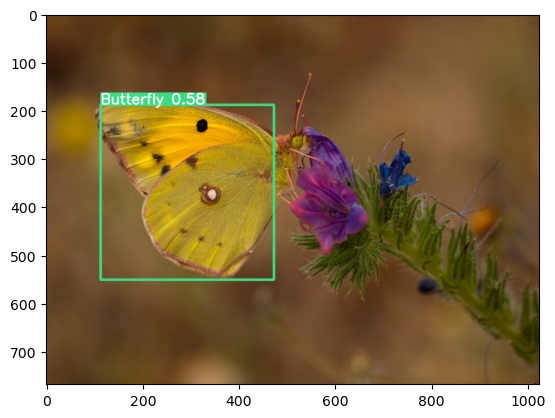

Class: 7   Bounding Box: (x1,y1,x2,y2)= [113.0, 188.0, 473.0, 551.0]  (confidence: 0.577896237373352 )


In [108]:
get_result(169)